In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ES_Twitch_Dataset/Train_Final.csv")
test = pd.read_csv("/content/drive/MyDrive/ES_Twitch_Dataset/Test_Final.csv")

In [ ]:
x_train = train.drop({'Target', 'Unnamed: 0'}, axis = 1)
y_train = train['Target']

In [ ]:
x_test = test.drop({'Target', 'Unnamed: 0'}, axis = 1)
y_test = test['Target']

In [ ]:
xgbc = xgb.XGBClassifier(random_state=35)

params = {"objective" :['binary:logistic', 'reg:logistic'],
          "max_depth": [4, 5, 6, 10, 15, 20],
          "n_estimators" : [50, 100, 150],
          "learning_rate" : [0.1, 0.2, 0.3, 0.4],
          "colsample_bytree" : [0.1, 0.2, 0.3, 0.4],
          "alpha" : [5, 10, 15, 20]
         }

model = RandomizedSearchCV(xgbc, params, random_state=35, n_jobs = 1, n_iter = 15, cv = 5, scoring="roc_auc")

### Entreno el modelo

In [ ]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=XGBClassifier(random_state=35), n_iter=15,
                   n_jobs=1,
                   param_distributions={'alpha': [5, 10, 15, 20],
                                        'colsample_bytree': [0.1, 0.2, 0.3,
                                                             0.4],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [4, 5, 6, 10, 15, 20],
                                        'n_estimators': [50, 100, 150],
                                        'objective': ['binary:logistic',
                                                      'reg:logistic']},
                   random_state=35, scoring='roc_auc')

Mejores hiperparametros encontrados

In [ ]:
best_params = model.best_estimator_.get_params()
best_params

{'alpha': 5,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:logistic',
 'random_state': 35,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

El Randomized Search ya me devuelve el mejor modelo posible, así que no es necesario volver a entrenar.

# Scores

Calculo el score para el set de entrenamiento

In [ ]:
roc_auc_score(y_train, model.predict_proba(x_train)[:,1])

0.9666420980602399

Calculo el score para el set de test:

In [ ]:
roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

0.8916735406587499

## Matriz de confusion

Text(0.5, 1.0, 'Confusion matrix')

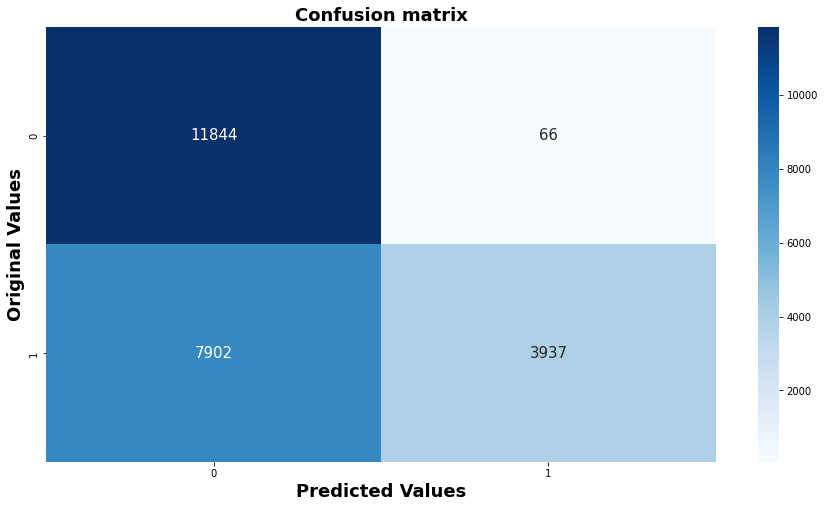

In [ ]:
C = confusion_matrix(y_test, model.predict(x_test))  
plt.figure(figsize=(15,8))
labels = [0,1]
sns.heatmap(C, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels, annot_kws={'size': 15})
plt.xlabel('Predicted Values', fontsize=18, fontweight='bold')
plt.ylabel('Original Values', fontsize=18, fontweight='bold')
plt.title("Confusion matrix", fontsize = 18, fontweight='bold')

## Features mas importantes

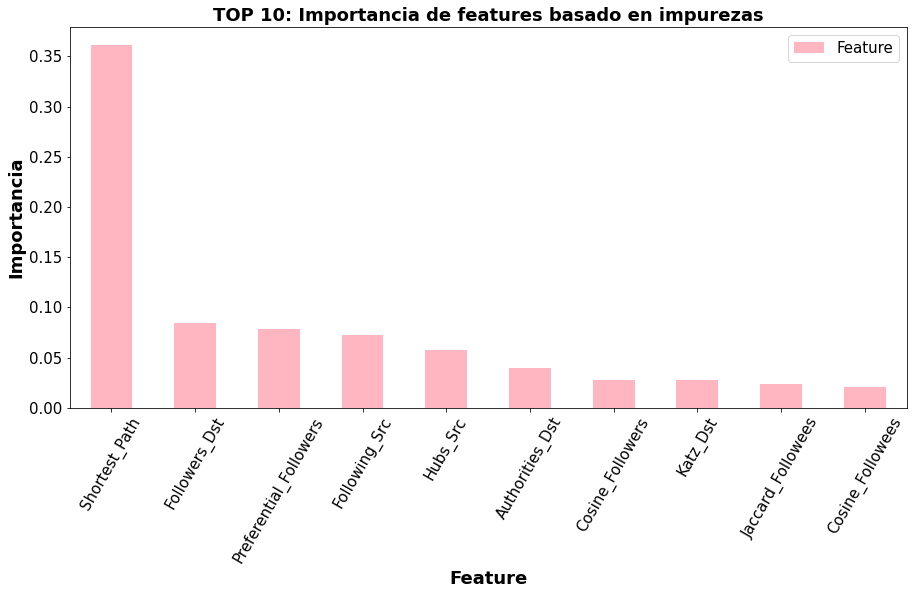

In [ ]:
xgbc = xgb.XGBClassifier(**best_params)
xgbc.fit(x_train, y_train)
importances = xgbc.feature_importances_
columns_names = list(x_train.columns.values)
dic = {}

for i in range(len(importances)):
  dic[columns_names[i]] = importances[i]

df = pd.DataFrame([[key, dic[key]] for key in dic.keys()], columns=['Feature', 'Importancia'])
df = df.sort_values('Importancia',ascending=False)
df.set_index('Feature',inplace = True)

df.iloc[0:10].plot.bar(logy=True, figsize=(15, 7), rot=60, color='lightpink', fontsize=15)
plt.title('TOP 10: Importancia de features basado en impurezas', fontsize = 18, fontweight='bold')
plt.xlabel('Feature', fontsize=18, fontweight='bold')
plt.ylabel('Importancia', fontsize=18, fontweight='bold')
plt.yscale(value='linear')
plt.legend(('Feature',), loc='upper right', prop={'size':15})

plt.show()